# VEME NGS Module: NS-Forest

This notebook demonstrates an example of running NS-Forest algorithm developed by Aevermann et al. to identify the minimum marker gene combininations that define a cell type.  We will apply this to the COVID-19 lung scRNA-seq response dataset to identify the markers genes for the provided cell types.  The pulication for NS-Forest can be found at https://genome.cshlp.org/content/31/10/1767

### Install the propper version of numpy.  v1.21.0 is required for using the anndata library

In [3]:
%pip uninstall numpy -y
%pip install numpy==1.21.0

Found existing installation: numpy 1.21.0
Uninstalling numpy-1.21.0:
  Successfully uninstalled numpy-1.21.0
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.21.0-cp38-cp38-macosx_10_9_x86_64.whl (16.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-network 0.31.0 requires numpy>=1.22.4, but you have numpy 1.21.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### ----- MUST RESTART THE KERNEL BEFORE RUNNING -----

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import nsforest as ns
import scanpy as sc
import warnings
import pickle
warnings.filterwarnings("ignore")

## 1.) Load in the processed cell by gene counts matrix

In [12]:
counts = pd.read_csv("processed_data_10_percent.csv.gz", compression = "gzip", index_col = 0)
counts.shape

(11631, 2000)

## 2.) Convert the cell by gene matrix to anndata data structure and annotate it

In [34]:
metadata = pd.read_csv("GSE171524_lung_metaData.txt", sep = "\t")

# Remove some unnecessary data
metadata = metadata.iloc[1:]
metadata = metadata[(metadata["cell_type_intermediate"] != "Other epithelial cells")]

# Get the metadata in the the downsampled counts matrix
metadata = metadata[(metadata["NAME"].isin(counts.index))]
counts = counts.loc[list(metadata["NAME"])]

# Appropriately sort the metadata to match order of cell name IDs in the counts matrix
metadata = metadata.set_index("NAME")
metadata = metadata.reindex(index = counts.index)
metadata = metadata.reset_index()

# Creat anndata object
adata = ad.AnnData(counts)
adata.obs_names = list(counts.index)
adata.var_names = list(counts.columns)

# Annotate the anndata with cell types
cell_types = list(metadata["cell_type_intermediate"])
adata.obs["cell_type"] = cell_types
adata

AnnData object with n_obs × n_vars = 11457 × 2000
    obs: 'cell_type'

## 3.) Run NS-Forest with the intermediate cell types

For an explanation on the NS-forest hyperparameters, see https://jcventerinstitute.github.io/celligrate/tutorials/NS-Forest_tutorial.html

In [24]:
NSForest_results = ns.NSForest(adata, cluster_header='cell_type', n_trees=100, n_genes_eval=6)
with open('ns_forest_100_trees.pkl', 'wb') as handle:
    pickle.dump(NSForest_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Preparing data...
--- 0.004282951354980469 seconds ---
Calculating medians...
--- 0.7389450073242188 seconds ---
Number of clusters to evaluate: 18
1 out of 18:
	AT1
	['RGS6', 'XKR4']
	0.8928079360705428
2 out of 18:
	AT2
	['SDR16C5', 'SFTPA1']
	0.8410194174757281
3 out of 18:
	Airway epithelial cells
	['AC019211.1', 'DCDC1']
	0.7731015553522416
4 out of 18:
	B cells
	['P2RY14', 'AC025887.2']
	0.7317073170731707
5 out of 18:
	CD4+ T cells
	['GREM2', 'NELL2']
	0.784279778393352
6 out of 18:
	CD8+ T cells
	Only 9 out of 15 top Random Forest features with median > 0 will be further evaluated.
	['CCL3', 'SGCD', 'AC104078.2']
	0.6118881118881119
7 out of 18:
	Cycling NK/T cells
	['FNDC1', 'KLHL14', 'AC005599.1']
	0.8082026537997586
8 out of 18:
	Dendritic cells
	['LINC02511', 'SLC18A2', 'CYYR1']
	0.7720588235294119
9 out of 18:
	Endothelial cells
	['NOTCH4', 'FENDRR']
	0.913113435237329
10 out of 18:
	Fibroblasts
	['PTGDS', 'SVEP1']
	0.9284678049324854
11 out of 18:
	Macrophages
	['IGSF21',

### Opening the pickeled version of the NS-Forest results, can save time ...

In [25]:
with open('ns_forest_100_trees.pkl', 'rb') as handle:
    NSForest_results = pickle.load(handle)

In [26]:
NSForest_results

,clusterName,clusterSize,f_score,PPV,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes
0,AT1,961,0.892808,0.971514,10477,19,313,648,2,"[RGS6, XKR4]","[CTSE, AC005165.1, GPRC5D, AC022325.2, RGS6, X..."
1,AT2,1072,0.841019,0.909449,10316,69,379,693,2,"[SDR16C5, SFTPA1]","[LAMP3, AC022101.1, C3orf79, SDR16C5, DPP10, S..."
2,Airway epithelial cells,778,0.773102,0.960227,10665,14,440,338,2,"[AC019211.1, DCDC1]","[ARMC3, LMNTD1, AC019211.1, DCDC1, AGBL4, TMPR..."
3,B cells,192,0.731707,0.960000,11262,3,120,72,2,"[P2RY14, AC025887.2]","[AP001636.3, ADAM28, P2RY14, MARCH1, AC025887...."
4,CD4+ T cells,816,0.784280,0.874517,10576,65,363,453,2,"[GREM2, NELL2]","[GREM2, LEF1, LINC02694, ST8SIA1, IL7R, NELL2,..."
5,CD8+ T cells,352,0.611888,0.707071,11047,58,212,140,3,"[CCL3, SGCD, AC104078.2]","[CCL3, SGCD, AC104078.2, DTHD1, AC243829.2, PP..."
6,Cycling NK/T cells,261,0.808203,0.943662,11188,8,127,134,3,"[FNDC1, KLHL14, AC005599.1]","[NELL2, FNDC1, KCNMB4, KLHL14, NCAPG, AC005599..."
7,Dendritic cells,96,0.772059,0.954545,11359,2,54,42,3,"[LINC02511, SLC18A2, CYYR1]","[LINC02511, AC099560.1, SLC18A2, CYYR1, STX17-..."
8,Endothelial cells,586,0.913113,0.955789,10850,21,132,454,2,"[NOTCH4, FENDRR]","[MCAM, EPAS1, NOTCH4, BTNL9, CAVIN2, FENDRR, R..."
9,Fibroblasts,2105,0.928468,0.970828,9302,50,441,1664,2,"[PTGDS, SVEP1]","[SCN7A, COL6A6, PTGDS, NFASC, SVEP1, ITGBL1, A..."


## 4.) Visualize the Results

### a. Marker Results

1.) Visualize markers with stacked violin plot

         Falling back to preprocessing with `sc.pp.pca` and default params.


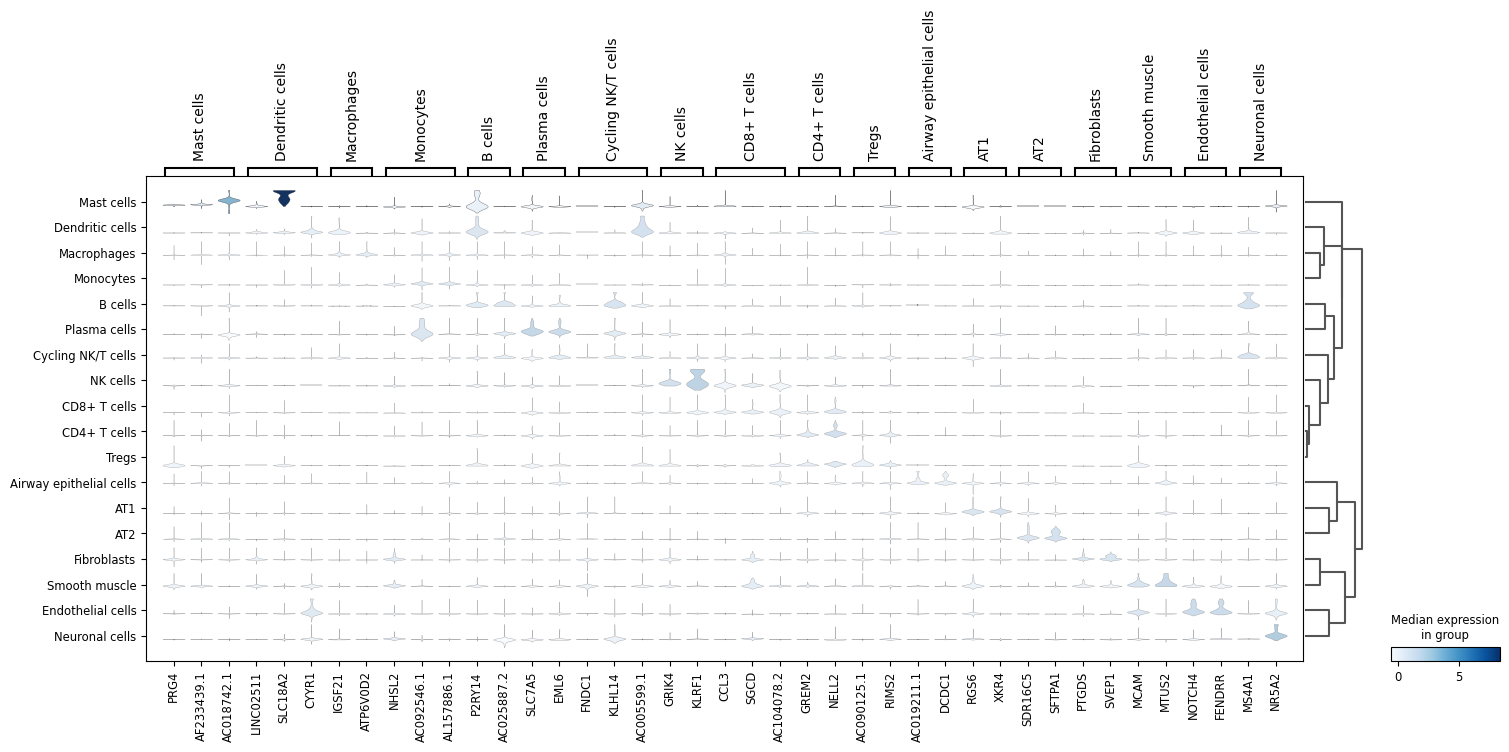

In [27]:
markers = dict(zip(NSForest_results['clusterName'], NSForest_results['NSForest_markers']))
sc.pl.stacked_violin(adata, markers, groupby='cell_type', dendrogram=True)

2.) Visualize markers with a matrix heatmap

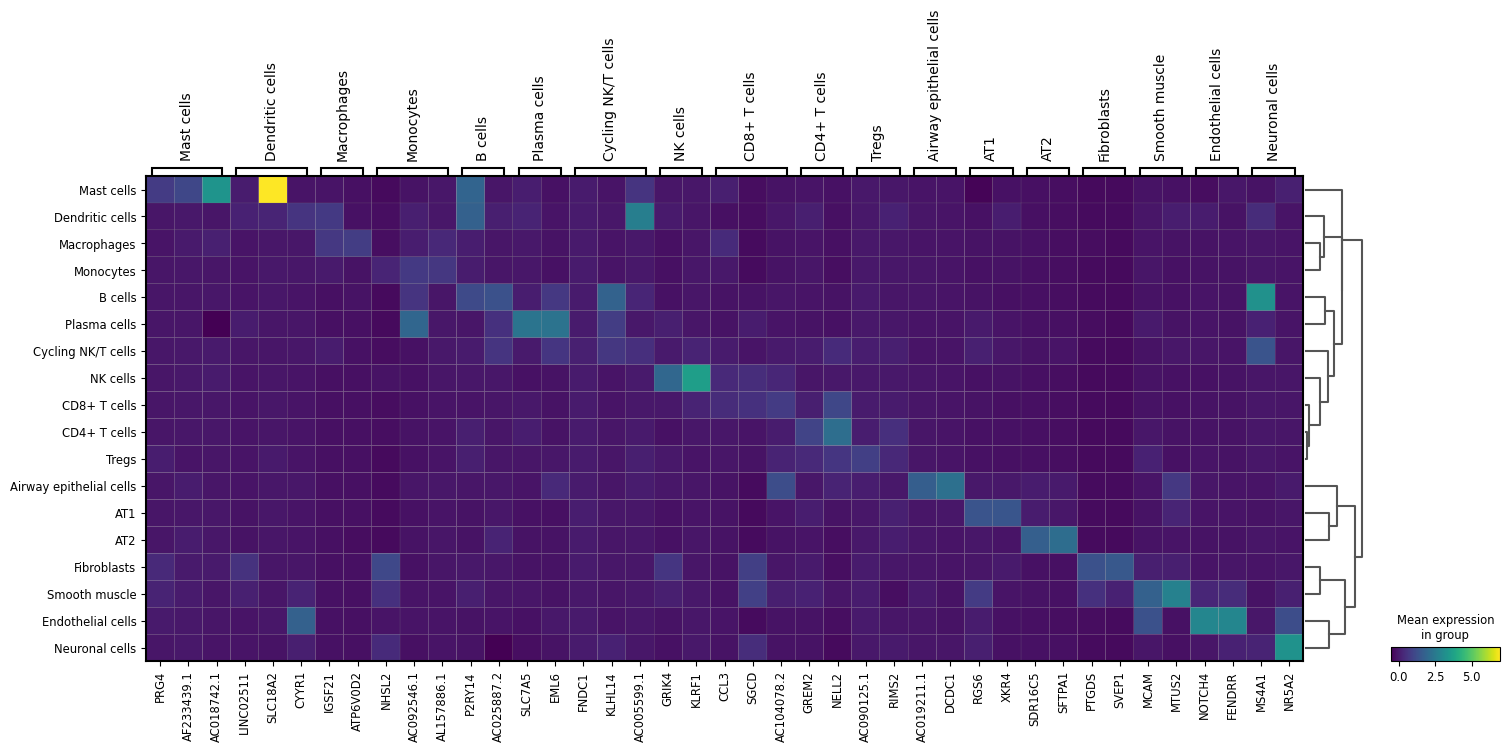

In [28]:
sc.pl.matrixplot(adata, markers, groupby='cell_type', dendrogram = True)

3.) Visualize markers with tracksplot

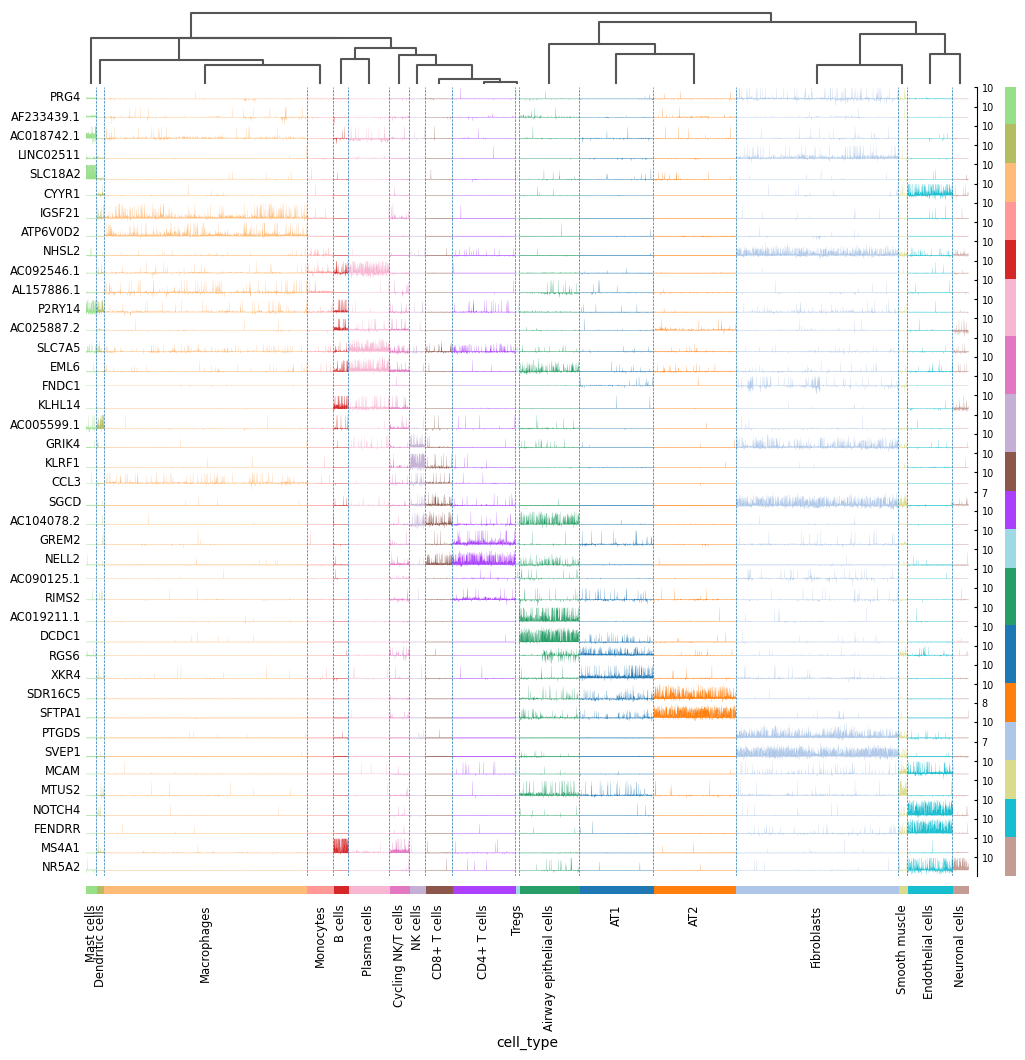

In [29]:
sc.pl.tracksplot(adata, markers, groupby='cell_type', dendrogram = True)

### b. Binary Gene Results

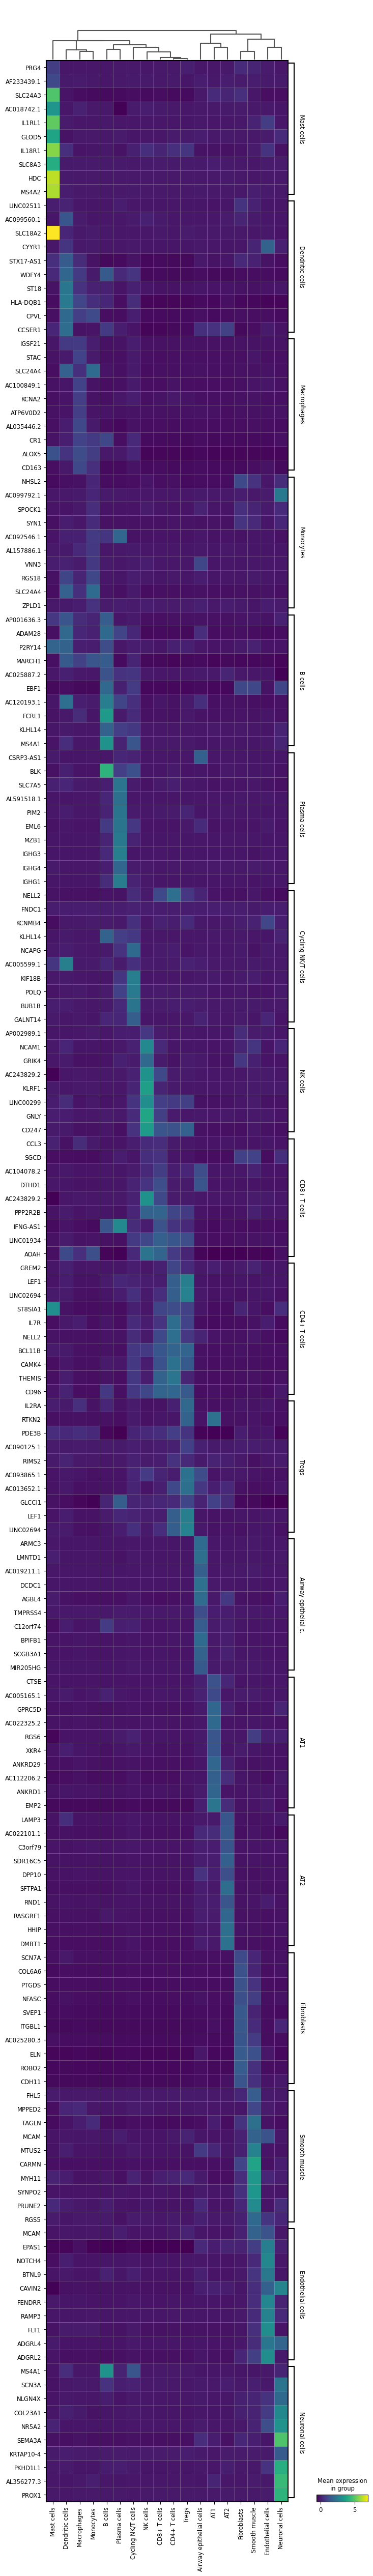

In [30]:
binary_genes = dict(zip(NSForest_results['clusterName'], NSForest_results['binary_genes']))
sc.pl.matrixplot(adata, binary_genes, groupby='cell_type', dendrogram=True, swap_axes=True)

## 5.) Exercise: Run NS-Forest with the main cell types

In [15]:
# Run this to annotate main cell type in the anndata structure

cell_type_main = list(metadata["cell_type_main"])
adata.obs["cell_type_main"] = cell_type_main
adata.obs

,cell_type,cell_type_main
ATTCACTGTAACAGGC-1_1,Airway epithelial cells,Epithelial cells
TAACTTCCAACCACGC-1_1,Macrophages,Myeloid
TTGGGTACACGACAAG-1_1,Airway epithelial cells,Epithelial cells
AGGCCACAGAGTCACG-1_1,Airway epithelial cells,Epithelial cells
CACTGAAGTCGAAGCA-1_1,Airway epithelial cells,Epithelial cells
...,...,...
CCTAAGAAGTTGTCAC-1_27,Fibroblasts,Fibroblasts
CGTGAATCATGTCTAG-1_27,Macrophages,Myeloid
GCCGATGAGTAAACGT-1_27,AT2,Epithelial cells
AGGGTGAGTATCAGGG-1_27,AT1,Epithelial cells


In [28]:
# Code to run NS-forest here

# Choose parameters from https://jcventerinstitute.github.io/celligrate/tutorials/NS-Forest_tutorial.html wisely:

# Recommended: Save the results to a pickle





In [30]:
# Code to visualize NS-forest results here:

# Go to https://scanpy-tutorials.readthedocs.io/en/latest/plotting/core.html to learn about plotting options in scanpy




